In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas
import time
from matplotlib import cm,ticker
import trap_sim_tools_python_trapSims_HOA.v2.expansion as ep

In [44]:
file_name = 'DC_bl1_100um_cubed_1mu_steps.fld'
full = file_name

df = pandas.read_csv(full, sep=' ', skiprows = 2, header = None)

# # if includes grid, use following
# df = df.iloc[:, [0,1,2,4]]
# # print (df.head(5))
# # print (df.tail(5))
# df.columns = ['X', 'Y','Z','V']
# print (df.head(5))
# print (df.tail(5))
# X = df.iloc[:,0].values
# Y = df.iloc[:,1].values
# Z = df.iloc[:,2].values
# V = df.iloc[:,3].values
# print (np.amin(np.abs(X)))

# if doesn't include grid, use this:
df.columns = ['V']
# print (df.head(5))
# print (df.tail(5))
V = df.iloc[:,0].values
x = np.arange(-50,51,1)
y = np.arange(-50,51,1)
z = np.arange(-50,51,1)
Z = np.tile(z,len(x)*len(y))
# print (Z)
Y = np.tile(y,(len(x),len(z)))
Y = np.ndarray.flatten(Y.T)
# print (Y)
X = np.tile(x,(len(y)*len(z),1))
X = np.ndarray.flatten(X.T)
# getting data of right electrodes from left electrodes
# X = -X
# print (X)
df['X'] = X
df['Y'] = Y
df['Z'] = Z

In [52]:
sorted_df = df.sort_values(by=['X', 'Y', 'Z'])
sorted_df = sorted_df.reset_index(drop=True)
sorted_df.iloc[:, 0].values

In [51]:
df

,V,X,Y,Z
0,0.000333,50,-50,-50
1,0.000332,50,-50,-49
2,0.000331,50,-50,-48
3,0.000330,50,-50,-47
4,0.000328,50,-50,-46
5,0.000327,50,-50,-45
6,0.000326,50,-50,-44
7,0.000325,50,-50,-43
8,0.000324,50,-50,-42
9,0.000322,50,-50,-41


In [8]:
ep.legendre(2, [0.01, 0.02, 0.03])

[array([-0.49985, -0.4994 , -0.49865]),
 array([-0.0299985 , -0.059988  , -0.08995949]),
 array([2.9997, 2.9988, 2.9973])]

In [94]:
# loading left electrodes
pot_data = []
for mod in ["tl", "bl"]:
    for i in [1, 2, 3, 4, 5]:
        file_name = 'DC_'+mod+str(i)+'_100um_cubed_1mu_steps.fld'
        full = file_name

        df = pandas.read_csv(full, sep=' ', skiprows = 2, header = None)
        df.columns = ['V']
        # print (df.head(5))
        # print (df.tail(5))
        V = df.iloc[:,0].values
        x = np.arange(-50,51,1)
        y = np.arange(-50,51,1)
        z = np.arange(-50,51,1)
        Z = np.tile(z,len(x)*len(y))
        # print (Z)
        Y = np.tile(y,(len(x),len(z)))
        Y = np.ndarray.flatten(Y.T)
        # print (Y)
        X = np.tile(x,(len(y)*len(z),1))
        X = np.ndarray.flatten(X.T)
        # print (X)
        df['X'] = X
        df['Y'] = Y
        df['Z'] = Z
        sorted_df = df.sort_values(by=['Z', 'Y', 'X'])
        sorted_df = sorted_df.reset_index(drop=True)
        pot_data.append(sorted_df.iloc[:, 0].values)

In [95]:
# loading right electrodes
for mod in ["tl", "bl"]:
    for i in [1, 2, 3, 4, 5]:
        file_name = 'DC_'+mod+str(i)+'_100um_cubed_1mu_steps.fld'
        full = file_name

        df = pandas.read_csv(full, sep=' ', skiprows = 2, header = None)
        df.columns = ['V']
        # print (df.head(5))
        # print (df.tail(5))
        V = df.iloc[:,0].values
        x = np.arange(-50,51,1)
        y = np.arange(-50,51,1)
        z = np.arange(-50,51,1)
        Z = np.tile(z,len(x)*len(y))
        # print (Z)
        Y = np.tile(y,(len(x),len(z)))
        Y = np.ndarray.flatten(Y.T)
        # print (Y)
        X = np.tile(x,(len(y)*len(z),1))
        X = np.ndarray.flatten(X.T)
        # convert from left to right
        X = -X
        # print (X)
        df['X'] = X
        df['Y'] = Y
        df['Z'] = Z
        sorted_df = df.sort_values(by=['Z', 'Y', 'X'])
        sorted_df = sorted_df.reset_index(drop=True)
        pot_data.append(sorted_df.iloc[:, 0].values)

In [96]:
len(pot_data)

20

In [97]:
M_matrix = []
for pot in pot_data:
    result = ep.spher_harm_expansion(pot, [0.0, 0.0, 0.0], np.linspace(-50, 50, 101), np.linspace(-50, 50, 101),\
                        np.linspace(-50, 50, 101), 2)
    M_raw = result[0]
    M = []
    for elem in M_raw:
        M.append(elem[0])
    M_matrix.append(np.array(M))
M_matrix = np.array(M_matrix)
M_matrix = M_matrix.transpose()

/Users/timothyguo/Desktop/Haeffner Group/Trap Design Testing/DC_Confinement/trap_sim_tools_python_trapSims_HOA/v2/expansion.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Mj=np.linalg.lstsq(Yj,W)


In [99]:
M_target = np.zeros(9)
M_target[6] = 1.0
print(M_target)

[0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [101]:
v = np.linalg.lstsq(M_matrix, M_target)
v = v[0]
print(v)

[  2312416.97206784  36685384.5417026   -1385895.0677354
  -6688328.47062585  -5449913.15785898   5017005.72542094
 -44715063.19471744   1176895.62330765  18279579.24814945
    390464.09637596  -2312416.97206794 -36685384.54170418
   1385895.06773697   6688328.47062328   5449913.15785817
  -5017005.72542202  44715063.19470908  -1176895.62330421
 -18279579.24815695   -390464.09637591]


/Users/timothyguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [102]:
fin_pot = np.zeros(len(pot_data[0]))
for i in range(20):
    fin_pot = fin_pot + v[i] * pot_data[i]
len(fin_pot)

1030301

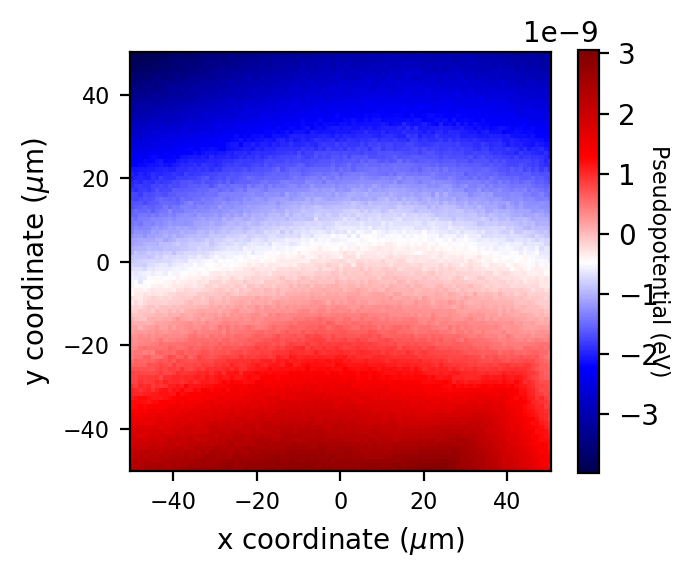

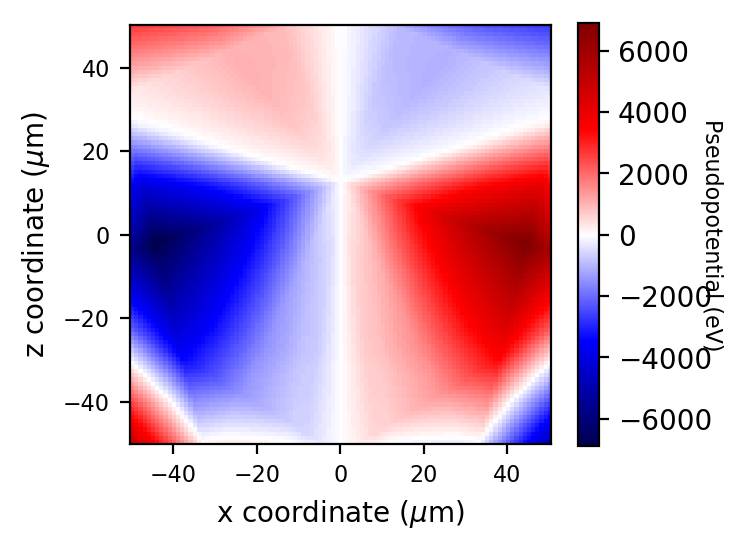

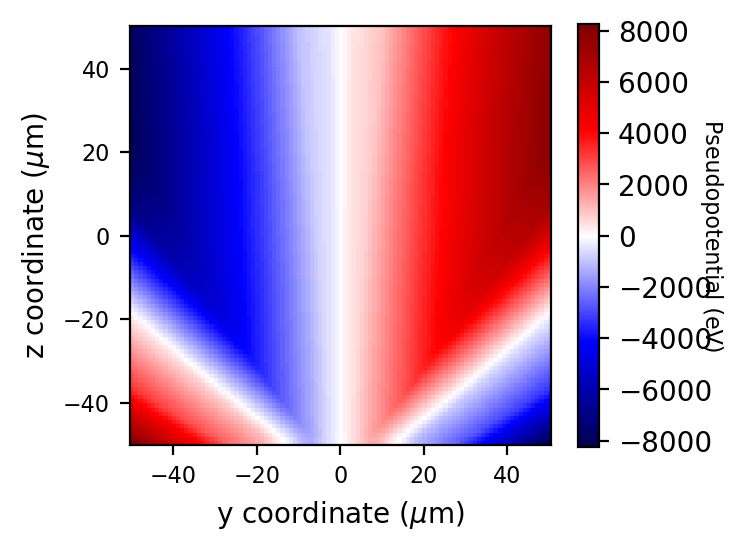

In [103]:
df = pandas.DataFrame(fin_pot)
# # if includes grid, use following
# df = df.iloc[:, [0,1,2,4]]
# # print (df.head(5))
# # print (df.tail(5))
# df.columns = ['X', 'Y','Z','V']
# print (df.head(5))
# print (df.tail(5))
# X = df.iloc[:,0].values
# Y = df.iloc[:,1].values
# Z = df.iloc[:,2].values
# V = df.iloc[:,3].values
# print (np.amin(np.abs(X)))

# if doesn't include grid, use this:
df.columns = ['V']
# print (df.head(5))
# print (df.tail(5))
V = df.iloc[:,0].values
x = np.arange(-50,51,1)
y = np.arange(-50,51,1)
z = np.arange(-50,51,1)
Z = np.tile(z,len(x)*len(y))
# print (Z)
Y = np.tile(y,(len(x),len(z)))
Y = np.ndarray.flatten(Y.T)
# print (Y)
X = np.tile(x,(len(y)*len(z),1))
X = np.ndarray.flatten(X.T)
# print (X)
df['X'] = X
df['Y'] = Y
df['Z'] = Z


# select cuts in the XY, XZ, YZ planes

# take all df entries where Z = 0
XY_matrix = df[df.Z == 0.0].loc[:, 'V'].values
V_XY = np.reshape(XY_matrix,(101,101))
# take all df entries where Y = 0
XZ_matrix = df[df.Y == 0.0].loc[:, 'V'].values
# print (XZ_matrix[99:110])
V_XZ = np.reshape(XZ_matrix,(101,101))
# take all df entries where X = 0
YZ_matrix = df[df.X == 0.0].loc[:, 'V'].values
# print (YZ_matrix[:10])
V_YZ = np.reshape(YZ_matrix,(101,101))

# XY plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
# im = plt.imshow(V_XY, interpolation='nearest', extent=[-50.5,50.5,-50.25,50.25], cmap=cm.seismic, vmin=np.log(1.E-3), vmax=np.log(100), origin = 'lower')
im = plt.imshow(V_XY, interpolation='none', extent=[-50.5,50.5,-50.25,50.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('DC potential due to DC_tl1 (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('x coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('y coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

# XZ plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
im = plt.imshow(V_XZ, interpolation='nearest', extent=[-50.5,50.5,-50.25,50.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('Pseudopotential (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('x coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('z coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

# YZ plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
im = plt.imshow(V_YZ, interpolation='nearest', extent=[-50.5,50.5,-50.25,50.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('Pseudopotential (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('y coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('z coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

